In [1]:
import pandas as pd
import numpy as np
import re
import scanpy as sc
import anndata
from concurrent.futures import ProcessPoolExecutor,ThreadPoolExecutor, as_completed
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
sc.settings.n_jobs = 60
import scyan
import os

Seed set to 0


In [2]:
def read_one(file_path):
    adata = scyan.read_csv(file_path,
                        marker_regex='^cd|^hla|tcr|ig|^ccr|klrg|^cx', 
                        exclude_markers=None)
    adata.obs["batch"] = re.findall( 'B\\d\\d\\d', file_path)[0]
    adata.obs["panel"] = re.findall( 'PB1|PT1|PM1|PS1', file_path)[0]

    return adata

# Assemble All 

In [3]:
meta_data=pd.read_csv('/home/jupyter/BRI_Figures/Dataset/FlowCyto_BRI_uuid.csv')

In [4]:
meta_data['pbmc_sample_id'] = meta_data['file.name'].apply(lambda x: re.search(r'PB([^_]+)', x).group(1) if re.search(r'PB([^_]+)', x) else None)
meta_data['pbmc_sample_id']=["PB" +x for x in meta_data['pbmc_sample_id']]
meta_data = meta_data.drop_duplicates(subset=['sample.sampleKitGuid'], keep='first').sort_values(by='sample.sampleKitGuid').reset_index(drop=True)

In [5]:
meta_data_selected_RNA=pd.read_csv('/home/jupyter/BRI_Figures/Dataset/scRNA_meta_data-2024-05-09.csv')

In [6]:
conditions = [
    (meta_data_selected_RNA['sample.drawDate'] <= '2020-07-01'),
    (meta_data_selected_RNA['sample.drawDate'] > '2020-07-01') & (meta_data_selected_RNA['sample.drawDate'] <= '2021-07-01'),
    (meta_data_selected_RNA['sample.drawDate'] > '2021-07-01') & (meta_data_selected_RNA['sample.drawDate'] <= '2022-07-01'),
    (meta_data_selected_RNA['sample.drawDate'] > '2022-07-01') & (meta_data_selected_RNA['sample.drawDate'] <= '2023-07-01')
]

choices = ['2019', '2020', '2021', '2022']

meta_data_selected_RNA['Flu_Year'] = np.select(conditions, choices, default=np.nan)

In [7]:
meta_data_selected_RNA=meta_data_selected_RNA.query("Flu_Year.isin(['2020','2021']) &`sample.visitName`.isin(['Flu Year 1 Day 0','Flu Year 1 Day 7','Flu Year 2 Day 0','Flu Year 2 Day 7'])")

In [8]:
meta_data_selected_RNA = pd.merge(meta_data_selected_RNA, meta_data, how='left', left_on=['sample.visitName', 'subject.subjectGuid'], right_on=['sample.visitName', 'subject.subjectGuid'])

In [9]:
meta_data=meta_data[meta_data['pbmc_sample_id'].isin(meta_data_selected_RNA['pbmc_sample_id_y'])]

In [10]:
#no day 7 sample on this years sample for this donor
meta_data=meta_data.query("~(`subject.subjectGuid`=='BR1026' & `sample.visitName`=='Flu Year 1 Day 0')")

# Read Data

In [11]:
%%time
file_names= ["/home/jupyter/BRI_Figures/Dataset/FlowCyto/"+ os.path.basename(x) for x in meta_data.reset_index()["file.name"]]
adata_list = []
with ThreadPoolExecutor(max_workers=60) as executor:
    future_to_file = {executor.submit(read_one, file_name): file_name for file_name in file_names}
    for future in tqdm(as_completed(future_to_file), total=len(file_names)):
        result = future.result()
        if result is not None:
            adata_list.append(result)

100% 314/314 [02:56<00:00,  1.78it/s]

CPU times: user 12min 19s, sys: 1min 24s, total: 13min 43s
Wall time: 2min 57s


In [12]:
adata = anndata.concat(adata_list)
adata.obs.index=adata.obs["barcode"].tolist()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
adata.obs['labels'].value_counts()

labels
naive_cd4_t_cells    14564020
myeloid_cells        10790869
Unknown               9741378
em_cd4_t_cells        9099846
cm_cd4_t_cells        8997829
cd56mid_nk_cells      8296546
b_cells               6473858
em_cd8_t_cells        5662379
naive_cd8_t_cells     5650478
temra_cd8_t_cells     4220975
gd_t_cells            2400148
memory_treg           1979230
debris                1264353
naive_treg             985046
cm_cd8_t_cells         872910
cd56hi_nk_cells        751737
dn_t_cells             747772
temra_cd4_t_cells      565121
dp_t_cells             429865
cd103_cd8_t_cells      410426
cd103_cd4_t_cells      174497
ilc_like_cells          66160
Name: count, dtype: int64

# Read h5 of CM CD4 T 

In [14]:
adata_CM_CD4=sc.read_h5ad('adata_cm_cd4_leiden_var15_umap.h5ad')

In [15]:
adata_sub_subsampled=sc.pp.subsample(adata_CM_CD4, n_obs=100000, random_state=0, copy=True)

/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_actio

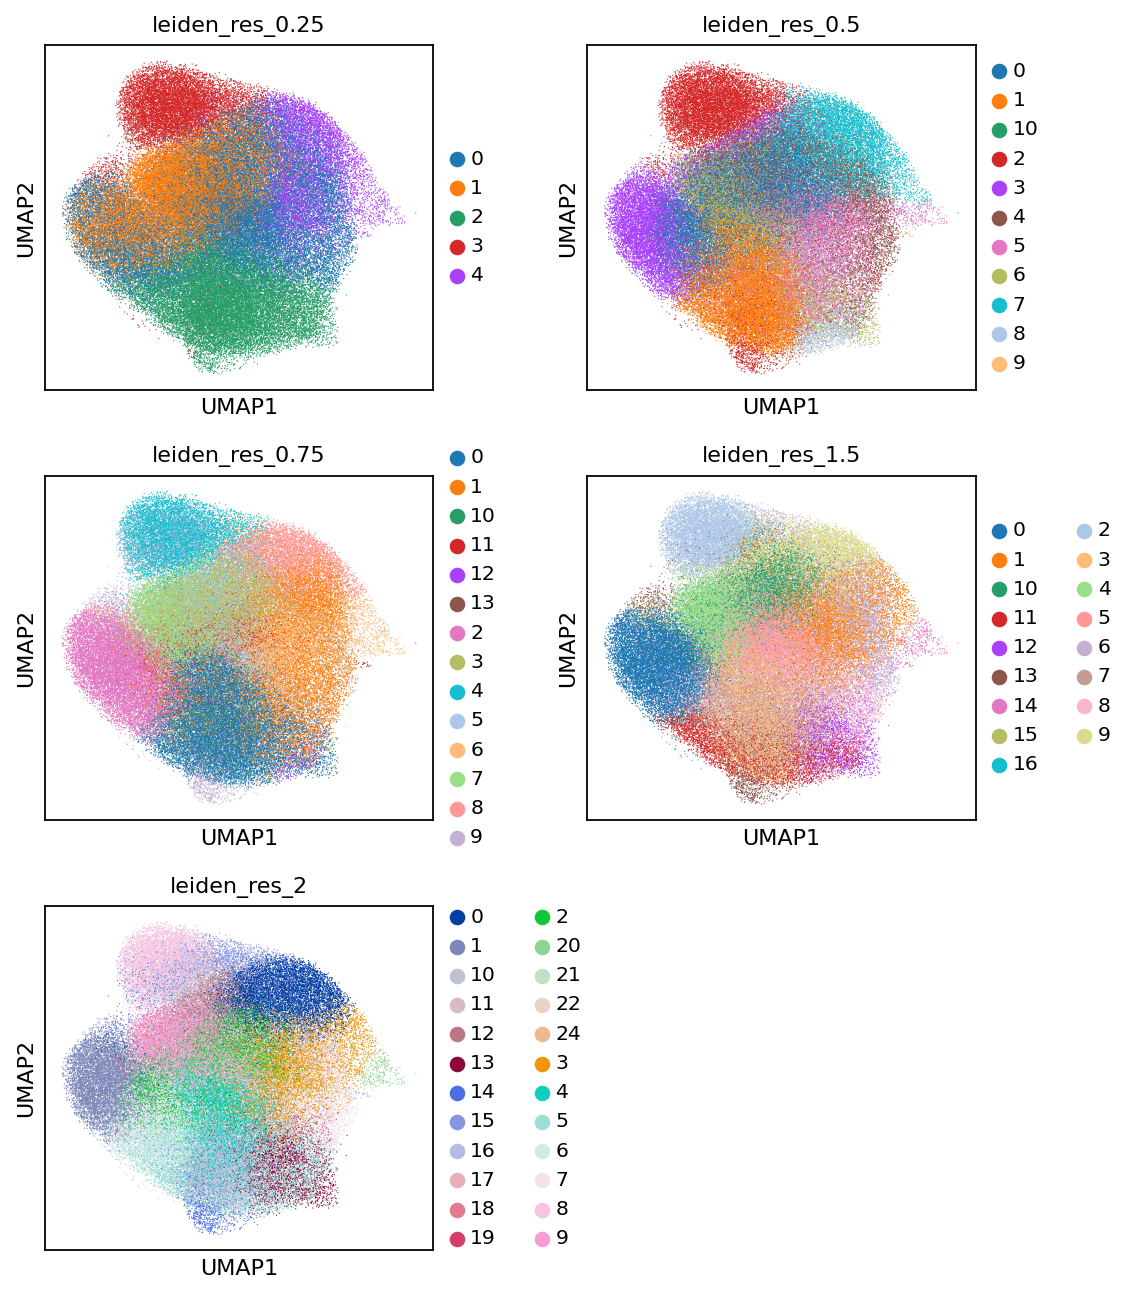

In [16]:
plt.rcParams['figure.figsize'] = [3, 3]

p1=scyan.plot.umap(adata_sub_subsampled, color=['leiden_res_0.25','leiden_res_0.5','leiden_res_0.75','leiden_res_1.5','leiden_res_2'], 
                   show=True, 
                   ncols=2 ,return_fig=True)


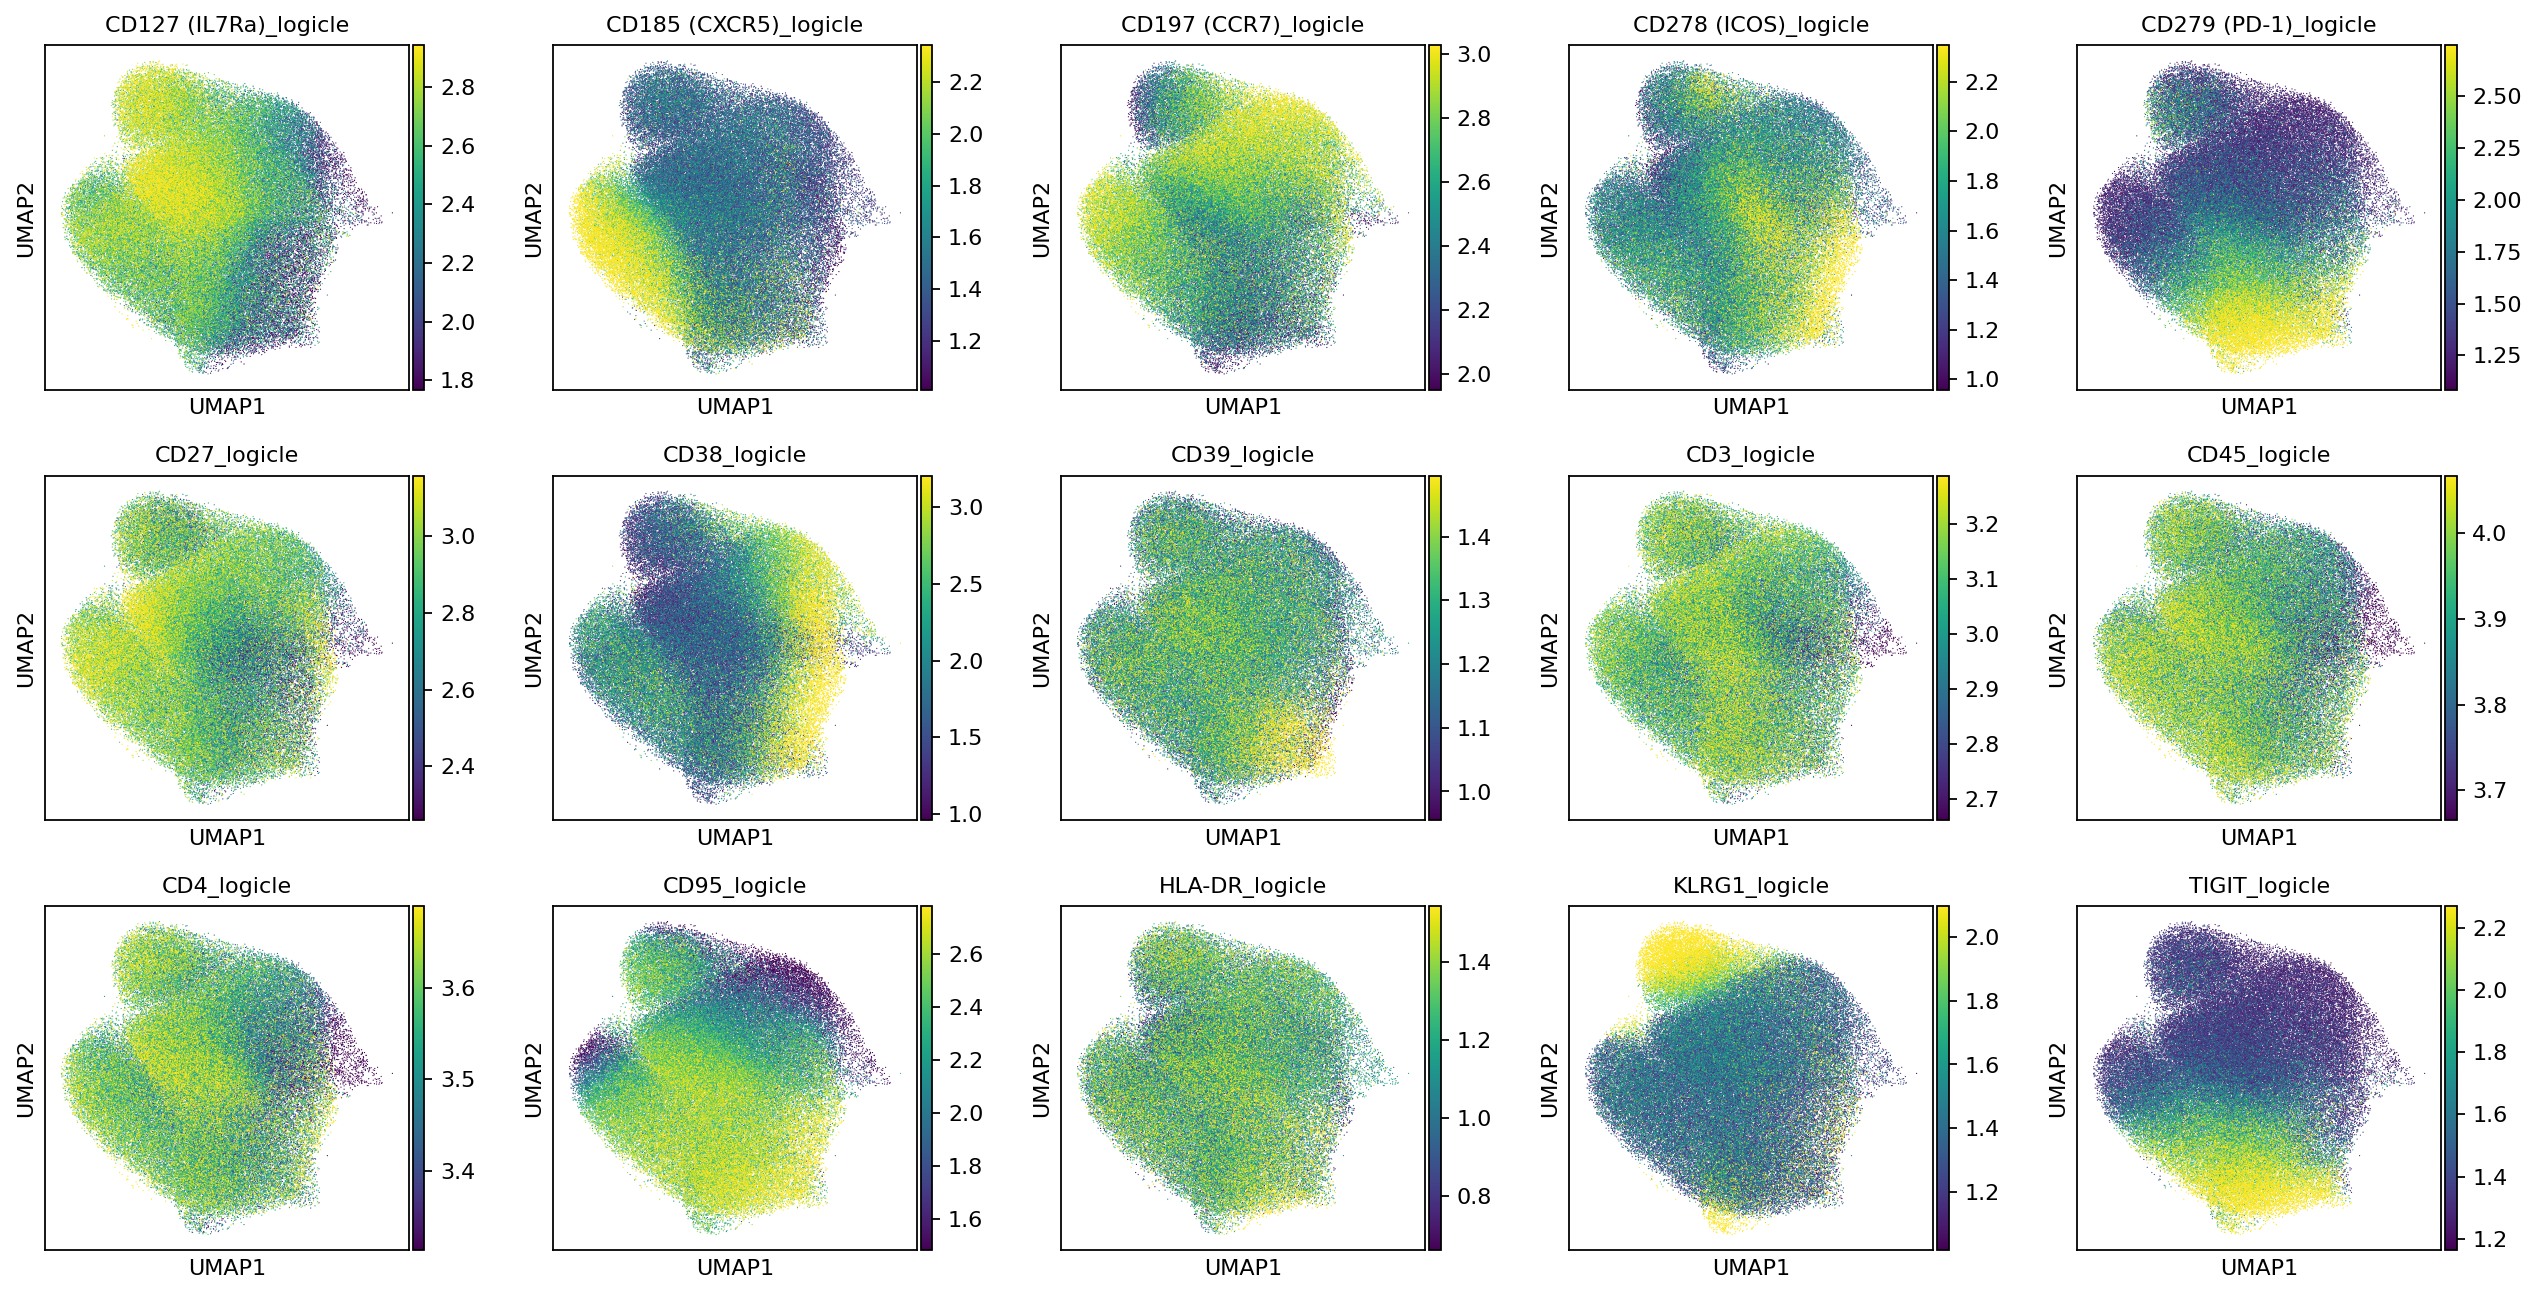

In [17]:
plt.rcParams['figure.figsize'] = [3, 3]

scyan.plot.umap(adata_sub_subsampled, color=adata_sub_subsampled.var_names.sort_values(),ncols=5, show=True)


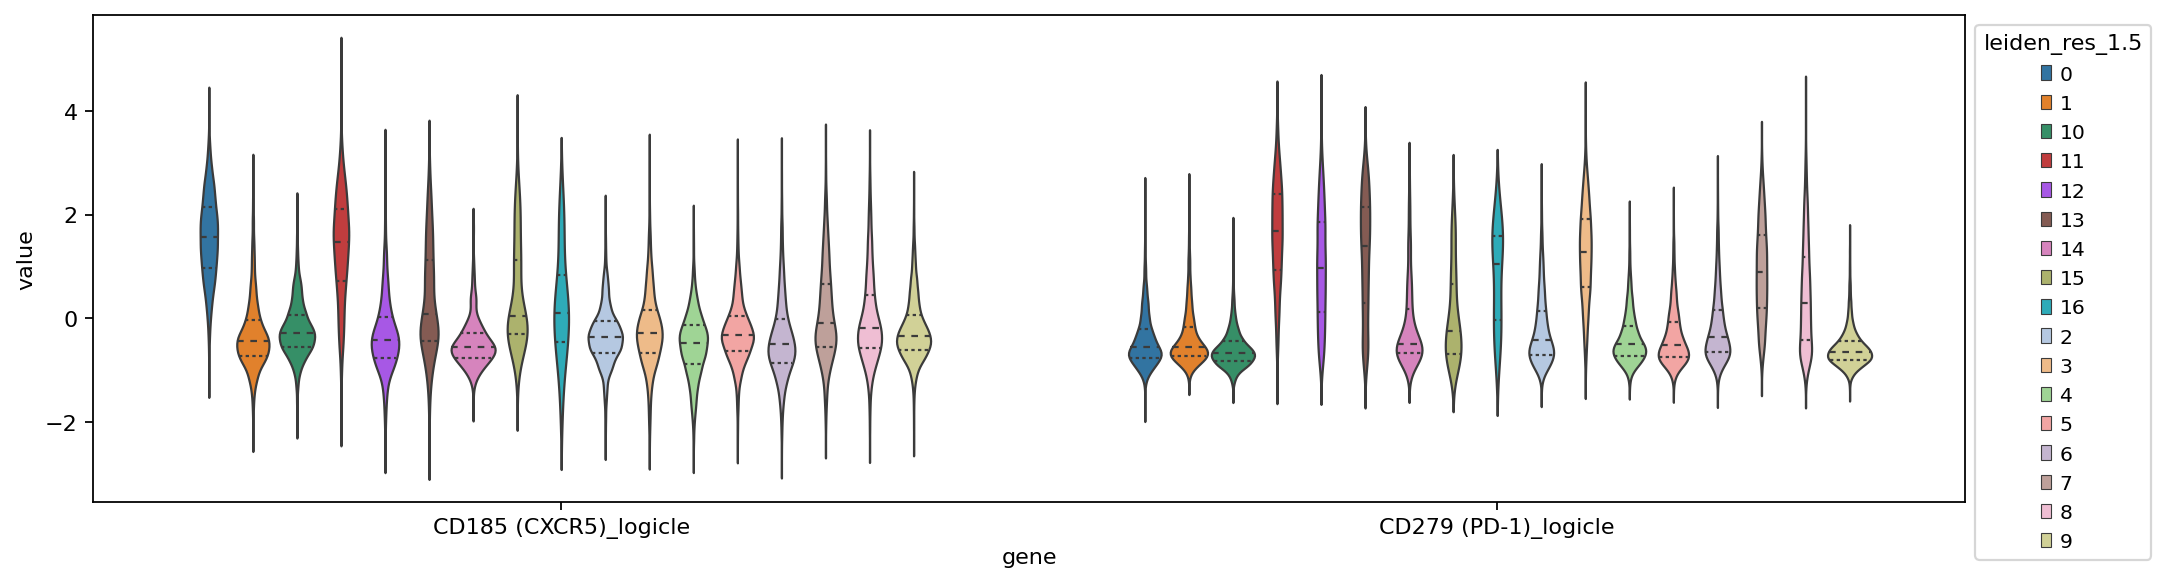

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15, 4]
df = sc.get.obs_df(adata_sub_subsampled, ['CD185 (CXCR5)_logicle','CD279 (PD-1)_logicle','leiden_res_1.5'])
df = df.set_index('leiden_res_1.5').stack().reset_index()
df.columns = ['leiden_res_1.5', 'gene', 'value']
ax=sns.violinplot(data=df, x='gene', y='value', hue="leiden_res_1.5",
                 inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [19]:
adata.obs['labels']=adata.obs['labels'].astype(str)


In [20]:
adata.obs.loc[adata.obs['barcode'].isin(adata_CM_CD4.obs[adata_CM_CD4.obs['leiden_res_1.5']=='0']['barcode']), 'labels'] = 'CXCR5+ PD1- Tfh'
adata.obs.loc[adata.obs['barcode'].isin(adata_CM_CD4.obs[adata_CM_CD4.obs['leiden_res_1.5']=='11']['barcode']), 'labels'] = 'CXCR5+ PD1+ Tfh'

In [21]:
counts=adata.obs[['labels','sample_id']].value_counts().unstack()

In [22]:
counts.to_csv('Counts.csv')

# Calculate Frequency

In [23]:
counts=pd.read_csv('Counts.csv')

In [24]:
T_cells=['CXCR5+ PD1+ Tfh',
 'CXCR5+ PD1- Tfh',
 'cd103_cd4_t_cells',
 'cd103_cd8_t_cells',
 'cm_cd4_t_cells',
 'cm_cd8_t_cells',
 'dn_t_cells',
 'dp_t_cells',
 'em_cd4_t_cells',
 'em_cd8_t_cells',
 'gd_t_cells',
 'memory_treg',
 'naive_cd4_t_cells',
 'naive_cd8_t_cells',
 'naive_treg',
 'temra_cd4_t_cells']
CD4_T_cells=['CXCR5+ PD1+ Tfh',
 'CXCR5+ PD1- Tfh',
 'cd103_cd4_t_cells',
 'cm_cd4_t_cells',
 'em_cd4_t_cells',
 'memory_treg',
 'naive_cd4_t_cells',
 'naive_treg',
 'temra_cd4_t_cells']

In [26]:
counts_T=counts[counts['labels'].isin(T_cells)]


### Freq in total T

In [41]:
counts_T=counts[counts['labels'].isin(T_cells)]
counts_T.index=counts_T['labels']
counts_T=counts_T.iloc[:,1:315]
frequency_matrix_T = counts_T.div(counts_T.sum(axis=0), axis=1)

In [42]:
frequency_matrix_reset = frequency_matrix_T.reset_index()
frequency_matrix_long = frequency_matrix_reset.melt(id_vars='labels', var_name='sample_id', value_name='frequency')

In [43]:
frequency_matrix_long['sample.sampleKitGuid']=['KT'+element.split('-')[0].replace("PB", "") for element in frequency_matrix_long['sample_id']]
metaData=meta_data_selected_RNA[['sample.sampleKitGuid_x','sample.visitName','subject.biologicalSex_x',
                        'cohort.cohortGuid_x','CMV' ,'subject.subjectGuid',
                        'Flu_Year']]
metaData.columns=['sample.sampleKitGuid','sample.visitName','subject.biologicalSex',
                        'cohort.cohortGuid','CMV' ,'subject.subjectGuid',
                        'Flu_Year']

In [44]:
frequency_matrix_long=frequency_matrix_long.merge(metaData, on='sample.sampleKitGuid', how='left')

In [45]:
frequency_matrix_long.to_csv('freq_T.csv')

### Freq in total CD4 T

In [46]:
counts_T=counts[counts['labels'].isin(CD4_T_cells)]
counts_T.index=counts_T['labels']
counts_T=counts_T.iloc[:,1:315]
frequency_matrix_T = counts_T.div(counts_T.sum(axis=0), axis=1)

In [47]:
frequency_matrix_reset = frequency_matrix_T.reset_index()
frequency_matrix_long = frequency_matrix_reset.melt(id_vars='labels', var_name='sample_id', value_name='frequency')

In [48]:
frequency_matrix_long['sample.sampleKitGuid']=['KT'+element.split('-')[0].replace("PB", "") for element in frequency_matrix_long['sample_id']]


In [49]:
metaData=meta_data_selected_RNA[['sample.sampleKitGuid_x','sample.visitName','subject.biologicalSex_x',
                        'cohort.cohortGuid_x','CMV' ,'subject.subjectGuid',
                        'Flu_Year']]
metaData.columns=['sample.sampleKitGuid','sample.visitName','subject.biologicalSex',
                        'cohort.cohortGuid','CMV' ,'subject.subjectGuid',
                        'Flu_Year']

In [50]:
frequency_matrix_long=frequency_matrix_long.merge(metaData, on='sample.sampleKitGuid', how='left')

In [51]:
frequency_matrix_long.to_csv('freq_CD4_T.csv')